In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
category_labels = np.load("/data/cogneuro/fMRI/categories/catloc_experimental_conditions.npy")

In [7]:
unique_category_labels = np.unique(category_labels)
unique_category_labels_no_nothing = unique_category_labels[unique_category_labels != 'nothing']
unique_category_labels_no_nothing

array(['body', 'faces', 'object', 'places', 'scrambled'], 
      dtype='<U9')

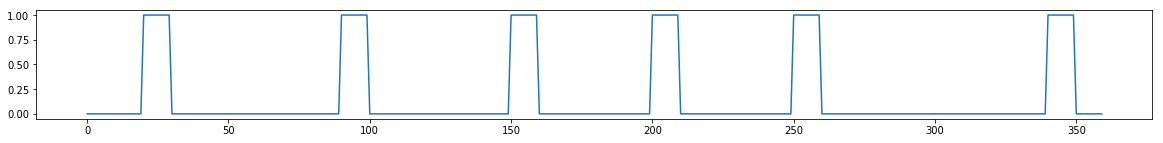

In [11]:
plt.figure(figsize=(20, 2))
plt.plot(category_labels == 'body')

In [12]:
stimulus_vectors = []
for category_label in unique_category_labels_no_nothing:
    stimulus_vectors.append(category_labels == category_label)

stimulus_design = np.stack(stimulus_vectors, axis=1)

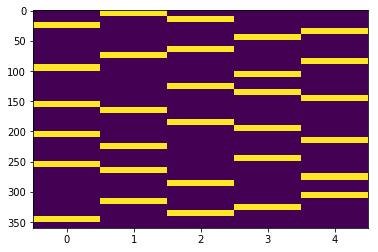

In [13]:
plt.imshow(stimulus_design, aspect='auto')

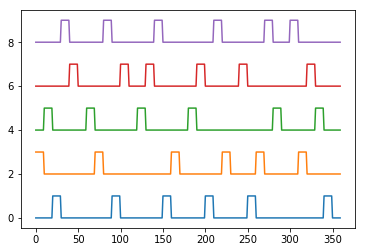

In [15]:
for i in range(stimulus_design.shape[1]):
    plt.plot(stimulus_design[:, i] + 2 * i)

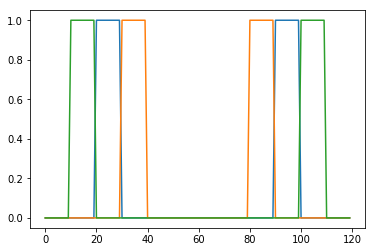

In [47]:
bodies = stimulus_design[:, 0]
plt.plot(bodies[:120])
plt.plot(bodies[120:240])
plt.plot(bodies[240:])


In [16]:
from nistats.hemodynamic_models import glover_hrf as create_hrf

In [18]:
hrf = create_hrf(tr=2, oversampling=1, time_length=32)

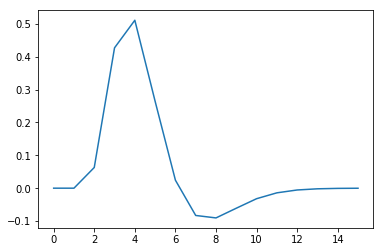

In [19]:
plt.plot(hrf)

In [27]:
response_vectors = []
for i in range(stimulus_design.shape[1]):
    stimulus_vector = stimulus_design[:, i]
    convolved_stimulus_vector = np.convolve(stimulus_vector, hrf)
    response_vector = convolved_stimulus_vector[:len(stimulus_vector)]
    response_vectors.append(response_vector)
    
response_design = np.stack(response_vectors, axis=1)


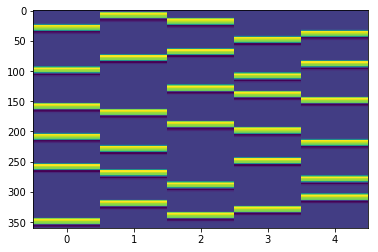

In [28]:
plt.imshow(response_design, aspect='auto')

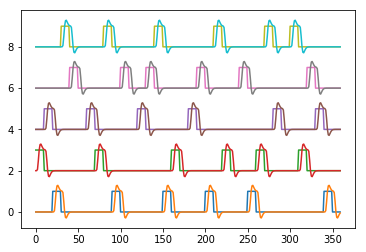

In [29]:
for i in range(stimulus_design.shape[1]):
    plt.plot(stimulus_design[:, i] + 2 * i)
    plt.plot(response_design[:, i] + 2 * i)

In [75]:
import nibabel
#from scipy.stats import zscore
def load_nifti(filename, z_score=True, mask=None):
    img = nibabel.load(filename)
    data = img.get_data().T
    if mask is not None:
        data = data[:, mask]
    if z_score:
        data -= data.mean(axis=0)
        data /= data.std(axis=0) + 1e-18
    return data

In [76]:
filenames = ["/data/cogneuro/fMRI/categories/s01_categories_01.nii.gz",
            "/data/cogneuro/fMRI/categories/s01_categories_02.nii.gz",
            "/data/cogneuro/fMRI/categories/s01_categories_03.nii.gz",]

In [77]:
import cortex
mask = cortex.db.get_mask('s01', 'catloc', 'cortical')

In [78]:
brain_data = []
for filename in filenames:
    data = load_nifti(filename, mask=mask)
    brain_data.append(data)


In [79]:
len(brain_data)

3

In [80]:
[bd.shape for bd in brain_data]

[(120, 38543), (120, 38543), (120, 38543)]

In [81]:
Ytrain = np.concatenate(brain_data[:2])
Ytest = brain_data[2]
Ytrain.shape, Ytest.shape

((240, 38543), (120, 38543))

In [82]:
Xtrain, Xtest = response_design[:240, :], response_design[240:, :]

In [83]:
from sklearn.linear_model import LinearRegression

In [84]:
lr = LinearRegression()

In [85]:
face_response_vector_train = Xtrain[:, 1] #response_design[:, 1]
face_response_vector_train.shape

(240,)

In [86]:
face_response_vector_train.reshape(-1, 1).shape

(240, 1)

In [87]:
lr.fit(face_response_vector_train.reshape(-1, 1), Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [93]:
face_response_vector_test = Xtest[:, 1]
face_response_vector_test = face_response_vector_test.reshape(120, 1)
face_response_vector_test.shape

(120, 1)

In [94]:
face_predictions = lr.predict(face_response_vector_test)

In [95]:
face_predictions.shape

(120, 38543)

In [99]:
errors = Ytest - face_predictions
errors.shape

(120, 38543)

In [100]:
mse = np.mean(errors ** 2, axis=0)

In [102]:
mse.shape

(38543,)

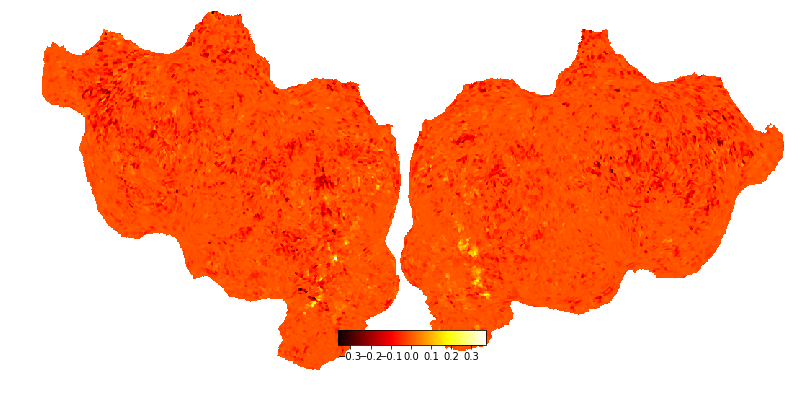

In [106]:
cortex.quickflat.make_figure(cortex.Volume(1 - mse, 's01', 'catloc', cmap='hot'))
pass

In [107]:
lr_full = LinearRegression()
lr_full.fit(Xtrain, Ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [108]:
predictions = lr_full.predict(Xtest)

In [109]:
errors = Ytest - predictions
mse = np.mean(errors ** 2, axis=0)

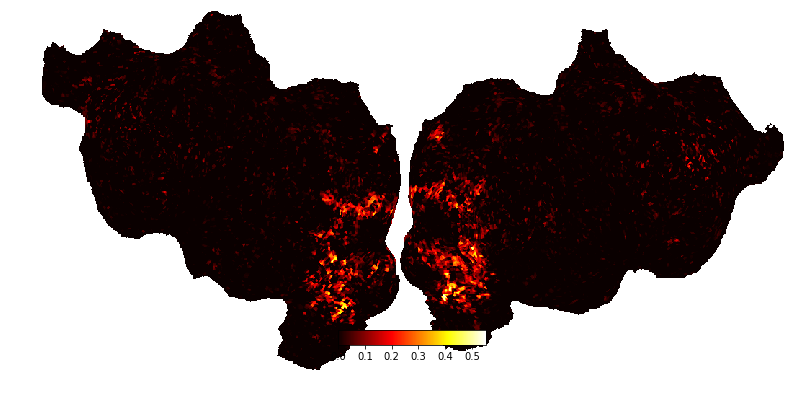

In [112]:
cortex.quickflat.make_figure(cortex.Volume(1 - mse, 's01', 'catloc', cmap='hot', vmin=0))
pass

In [115]:
y = np.concatenate(brain_data, axis=0)
y.shape

(360, 38543)

In [116]:
model_contrast = LinearRegression()
model_contrast.fit(response_design, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [117]:
unique_category_labels_no_nothing

array(['body', 'faces', 'object', 'places', 'scrambled'], 
      dtype='<U9')

In [118]:
model_contrast.coef_.shape

(38543, 5)

In [119]:
contrast_LO = model_contrast.coef_[:,2] - model_contrast.coef_[:,4]
contrast_LO.shape

(38543,)

In [120]:
contrast_LO.reshape(-1,1).shape

(38543, 1)

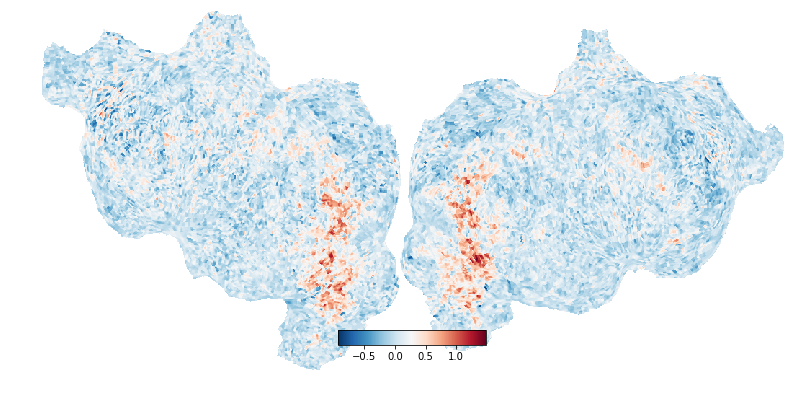

In [122]:
_ = cortex.quickflat.make_figure(cortex.Volume(contrast_LO, 's01', 'catloc'))

In [126]:
_ = cortex.webshow({'contrastLO':cortex.Volume(contrast_LO, 's01', 'catloc'), 'mseModel':cortex.Volume(1-mse, 's01', 'catloc')})

Started server on port 8474


['rois']
